# Importing required Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt


# Checking if there's any corrupted data

In [2]:
#Remove any photos that are corrupted.Corrupted photographs are prevalent when working with large amounts of real-world
#image data. Let's filter out photos that aren't encoded correctly and don't have the string "JFIF" in their header.

num_skipped = 0
for folder_name in ("cats", "dogs",'panda'):
    folder_path = os.path.join(r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\images", folder_name)
    for fname in os.listdir(folder_path):
        #print(fname)
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


# Splitting data into train and validation data

In [3]:
image_size = (180, 180) #We will try to resize all the images to this size
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


# Lets see the preview of images

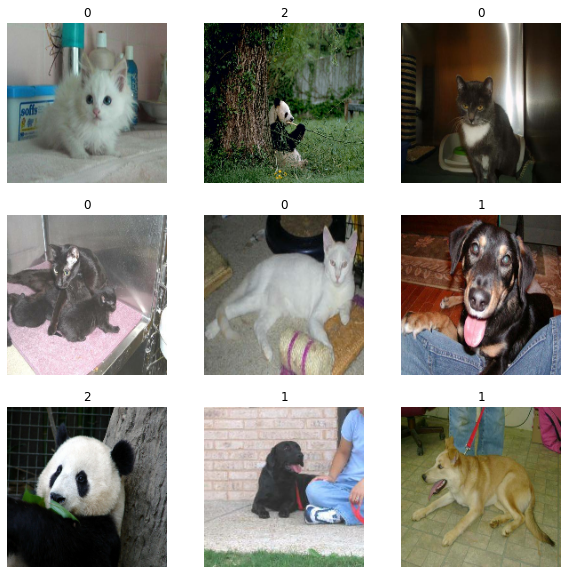

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

##### We can see that model is mapping images with labels as - cat:0, dog: 1, panda:2 

# Using Data Augmentation to make models more robust

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(height_factor=0.2,width_factor=0.2),
        layers.RandomContrast(0.2)
    ]
)

# Augmented Data Visualization

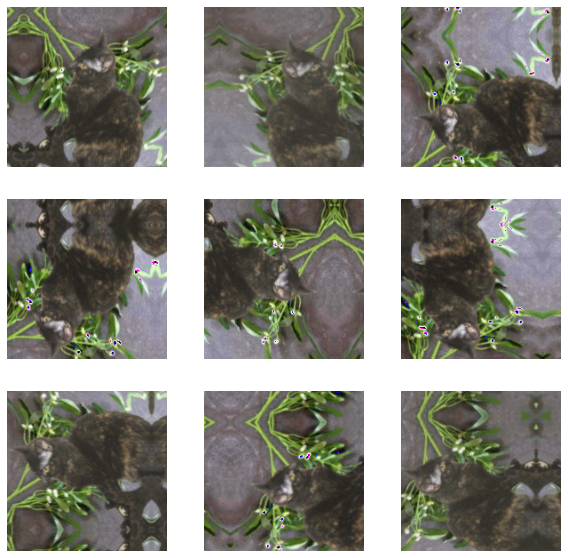

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[2].numpy().astype("uint8"))
        plt.axis("off")

# Configuring dataset for performance

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def model_def(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


In [9]:
input_shape = image_size + (3,)
model = model_def(input_shape=input_shape)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy", #Since it is multiclass and images are not one hot encoded.
    metrics=["accuracy"]
)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                           

In [12]:
epochs = 50

callbacks = [
    
keras.callbacks.ModelCheckpoint
    (r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\best_moodel.h5", 
     monitor='val_loss', mode='min', save_best_only=True) #--------------saving the best model
]

history1 = model.fit(
    train_ds, epochs=epochs, callbacks = callbacks, validation_data=val_ds
)


Epoch 1/50
75/75 [==============================] - 18s 230ms/step - loss: 1.1444 - accuracy: 0.5412 - val_loss: 3.9327 - val_accuracy: 0.3217
Epoch 2/50
75/75 [==============================] - 18s 230ms/step - loss: 0.8625 - accuracy: 0.5704 - val_loss: 3.8120 - val_accuracy: 0.3117
Epoch 3/50
75/75 [==============================] - 18s 233ms/step - loss: 0.8141 - accuracy: 0.6008 - val_loss: 2.3481 - val_accuracy: 0.3350
Epoch 4/50
75/75 [==============================] - 18s 233ms/step - loss: 0.8047 - accuracy: 0.6171 - val_loss: 1.7238 - val_accuracy: 0.3300
Epoch 5/50
75/75 [==============================] - 18s 235ms/step - loss: 0.7465 - accuracy: 0.6533 - val_loss: 1.9104 - val_accuracy: 0.3183
Epoch 6/50
75/75 [==============================] - 18s 237ms/step - loss: 0.7437 - accuracy: 0.6442 - val_loss: 1.0754 - val_accuracy: 0.4700
Epoch 7/50
75/75 [==============================] - 19s 244ms/step - loss: 0.7331 - accuracy: 0.6525 - val_loss: 0.8574 - val_accuracy: 0.5833

# loading the saved model

In [18]:
from keras.models import load_model
saved_model = load_model(r'C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\best_moodel.h5')

# Predicting class of unseen images

In [19]:
img = keras.preprocessing.image.load_img(
    r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\rax.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = saved_model.predict(img_array) #using the loaded model to predict the class of new image


In [20]:
def predict(predictions):
    pred_val = predictions[0]
    if pred_val[0]==max(pred_val):
        print('Image classified as Cat with {} % probability'.format(round(pred_val[0]*100),2),plt.imshow(img))
    elif pred_val[1]==max(pred_val):
        print('Image classified as Dog with {} % probability'.format(round(pred_val[1]*100),2),plt.imshow(img))
    else:
        print('Image classified as Panda with {} % probability'.format(round(pred_val[2]*100),2),plt.imshow(img))

Image classified as Panda with 96 % probability AxesImage(54,36;334.8x217.44)


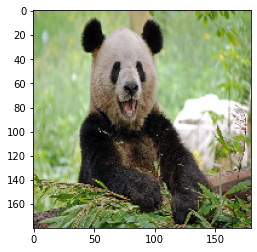

In [21]:
predict(predictions)

# Transfer Learning

In [22]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception


xception_model  = Xception(weights='imagenet',include_top=False,input_shape =  input_shape)
# include-top = false: Leave out the last fully connected layer

for layer in xception_model.layers[:-4]:
    layer.trainable = False            # unfreezing last 4 layers so that we can train our data on these layers

def transfer_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Rescaling(1./255)(x)
    x = xception_model(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same",activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


In [23]:
transfer_model = transfer_model(input_shape=input_shape)
transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 32)          589856    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                           

In [22]:
epochs = 50

callbacks = [
    
keras.callbacks.ModelCheckpoint
    (r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\best_model.h5", 
                                    monitor='val_loss', mode='min', save_best_only=True)
]

history2 = transfer_model.fit(
    train_ds, epochs=epochs, callbacks = callbacks, validation_data=val_ds
)


Epoch 1/50
75/75 [==============================] - 102s 1s/step - loss: 0.4915 - accuracy: 0.7946 - val_loss: 0.0889 - val_accuracy: 0.9733


C:\Users\namra\anaconda31\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/50
75/75 [==============================] - 103s 1s/step - loss: 0.3018 - accuracy: 0.8871 - val_loss: 0.0841 - val_accuracy: 0.9717
Epoch 3/50
75/75 [==============================] - 103s 1s/step - loss: 0.2688 - accuracy: 0.8967 - val_loss: 0.0782 - val_accuracy: 0.9800
Epoch 4/50
75/75 [==============================] - 104s 1s/step - loss: 0.2478 - accuracy: 0.9079 - val_loss: 0.0819 - val_accuracy: 0.9700
Epoch 5/50
75/75 [==============================] - 107s 1s/step - loss: 0.2485 - accuracy: 0.9083 - val_loss: 0.1074 - val_accuracy: 0.9617
Epoch 6/50
75/75 [==============================] - 107s 1s/step - loss: 0.2375 - accuracy: 0.9179 - val_loss: 0.0882 - val_accuracy: 0.9717
Epoch 7/50
75/75 [==============================] - 105s 1s/step - loss: 0.2138 - accuracy: 0.9262 - val_loss: 0.1046 - val_accuracy: 0.9733
Epoch 8/50
75/75 [==============================] - 105s 1s/step - loss: 0.1991 - accuracy: 0.9287 - val_loss: 0.0925 - val_accuracy: 0.9750
Epoch 9/50
75

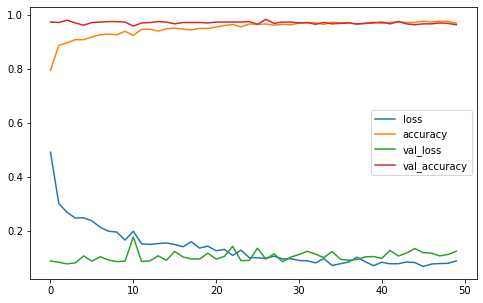

In [23]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

### We can observe that training loss eventually reduced and train, test accuracies are almost same which implies that data is neither over-fitting nor under-fitting

# Loading the saved model

In [26]:
from keras.models import load_model
saved_model1 = load_model(r'C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\best_model.h5')

In [27]:
img = keras.preprocessing.image.load_img(
    r"C:\Users\namra\OneDrive\Documents\Deep_Leaarning\Zoo Classifier project - images\rax.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

transfer_predict = saved_model1.predict(img_array)


Image classified as Panda with 100 % probability AxesImage(54,36;334.8x217.44)


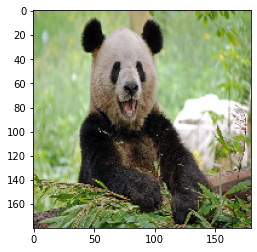

In [28]:
predict(transfer_predict)

## We can see that the same image predicted by two models we built, predicts the image as 'panda' with 96% and 100% respectively.